### Import

In [1]:
import duckdb
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from google.cloud import storage
import re

### variables

## Positions

In [2]:
def duck_to_pandas(database_path, query):
    """
    Conecta ao DuckDB, executa a consulta SQL fornecida e retorna os resultados como um DataFrame do pandas.

    Args:
    - database_path (str): O caminho para o arquivo do banco de dados DuckDB.
    - query (str): A consulta SQL a ser executada.

    Returns:
    - pd.DataFrame: DataFrame contendo os resultados da consulta SQL.
    """
    try:
        # Conectar ao banco de dados DuckDB
        con = duckdb.connect(database=database_path, read_only=False)

        # Executar a consulta SQL e carregar os resultados em um DataFrame do pandas
        df = con.execute(query).df()

        # Fechar a conexão
        con.close()

        return df
    except Exception as e:
        print(f"Erro ao executar a consulta: {e}")
        return None

In [7]:
database_path = 'telemetria.duckdb'
query = "SELECT * FROM positions_"
df_positions = duck_to_pandas(database_path, query)

### EDA

In [8]:
#Usar o datawrangler para visualizar os dados

In [9]:
df_positions.describe()

,Longitude,Latitude,DriverId,AssetId,PositionId,OdometerKilometres,AgeOfReadingSeconds,Pdop,Hdop,NumberOfSatellites,Heading,AltitudeMetres,SpeedKilometresPerHour,SpeedLimit
count,2.861310e+06,2.861310e+06,2.861310e+06,2.861310e+06,2.861310e+06,2.857860e+06,2.861310e+06,2861296.0,2.861310e+06,2.861310e+06,2.861310e+06,1090125.0,2.861310e+06,1.020353e+06
mean,-4.928310e+01,-1.669824e+01,5.043319e+17,1.505073e+18,3.304818e+18,6.697207e+05,4.202312e+02,0.0,1.810838e+00,1.195400e+01,1.751592e+02,0.0,1.895042e+01,5.305794e+01
std,3.620484e-02,6.314757e-02,8.266153e+17,8.714745e+15,1.260722e+16,5.387774e+05,1.033417e+04,0.0,4.339789e+00,4.620112e-01,1.036577e+02,0.0,1.409634e+01,1.060326e+01
min,-4.948704e+01,-2.352033e+01,-8.208205e+18,1.498924e+18,3.275198e+18,1.000000e-02,0.000000e+00,0.0,0.000000e+00,4.000000e+00,0.000000e+00,0.0,0.000000e+00,2.000000e+01
25%,-4.929878e+01,-1.671175e+01,-1.066474e+17,1.498925e+18,3.295412e+18,4.921563e+05,0.000000e+00,0.0,1.000000e+00,1.200000e+01,7.900000e+01,0.0,4.366000e+00,4.000000e+01
50%,-4.928387e+01,-1.668846e+01,-1.066474e+17,1.498925e+18,3.306043e+18,6.145204e+05,0.000000e+00,0.0,1.000000e+00,1.200000e+01,1.720000e+02,0.0,2.049000e+01,6.000000e+01
75%,-4.926364e+01,-1.667407e+01,1.491699e+18,1.514417e+18,3.315412e+18,9.128918e+05,2.000000e+00,0.0,1.000000e+00,1.200000e+01,2.580000e+02,0.0,2.959800e+01,6.000000e+01
max,-4.667695e+01,-1.658963e+01,9.135806e+18,1.547012e+18,3.324552e+18,4.050610e+06,1.144871e+06,0.0,2.500000e+01,1.200000e+01,3.590000e+02,0.0,1.103850e+02,1.100000e+02


In [10]:
df_positions.dtypes

Timestamp                  object
Longitude                 float64
Latitude                  float64
DriverId                    int64
AssetId                     int64
PositionId                  int64
IsAvl                        bool
Source                     object
OdometerKilometres        float64
AgeOfReadingSeconds         int64
Pdop                      float64
Hdop                        int64
NumberOfSatellites          int64
Heading                     int64
AltitudeMetres            float64
SpeedKilometresPerHour    float64
FormattedAddress           object
SpeedLimit                float64
dtype: object

In [11]:
df_positions.isna().sum()

Timestamp                       0
Longitude                       0
Latitude                        0
DriverId                        0
AssetId                         0
PositionId                      0
IsAvl                           0
Source                          0
OdometerKilometres           3450
AgeOfReadingSeconds             0
Pdop                           14
Hdop                            0
NumberOfSatellites              0
Heading                         0
AltitudeMetres            1771185
SpeedKilometresPerHour          0
FormattedAddress          1279752
SpeedLimit                1840957
dtype: int64

### Casting

In [ ]:
# df_positions['Timestamp'] = pd.to_datetime(df_positions['Timestamp'])

### Persisting database in file duckdb

In [ ]:
# con.execute("CREATE TABLE positions AS SELECT * FROM df_positions")
# con.close()

In [12]:
hdop_counts = df_positions['Hdop'].value_counts()
hdop_percentages = df_positions['Hdop'].value_counts(normalize=True) * 100
hdop_summary = pd.DataFrame({
    'Count': hdop_counts,
    'Percentage': hdop_percentages
})
hdop_summary.reset_index().sort_values(by='Hdop', ascending=True)

,Hdop,Count,Percentage
2,0,7576,0.264774
0,1,2754144,96.254653
3,2,1920,0.067102
4,3,438,0.015308
5,4,173,0.006046
6,5,101,0.003530
7,6,79,0.002761
8,7,48,0.001678
9,8,23,0.000804
10,9,20,0.000699


#### Tratando os dados nulos no campo de Formatted Address

In [ ]:
# import googlemaps
# from dotenv import load_dotenv
# from concurrent.futures import ThreadPoolExecutor
# load_dotenv()

In [ ]:
# api_key = os.getenv('GOOGLE_MAPS_API_KEY')
# gmaps = googlemaps.Client(key=api_key)

In [ ]:
# def reverse_geocode(lat, lon):
#     try:
#         result = gmaps.reverse_geocode((lat, lon))
#         if result:
#             return result[0]['formatted_address']
#         else:
#             return None
#     except Exception as e:
#         return None

In [ ]:
# def process_row(row):
    # return reverse_geocode(row['Latitude'], row['Longitude'])

In [ ]:
# geo_address = df_positions[['Latitude', 'Longitude']].dropna().head(1000)

In [ ]:
# with ThreadPoolExecutor(max_workers=10) as executor:
#     geo_address['Address'] = list(executor.map(lambda row: process_row(row), [row for _, row in geo_address.iterrows()]))

# print(geo_address)

Neste estudo utilizamos 2 API's paga (Google Maps) e Gratuita (Nominatim). A limitação da gratuíta, é que as requisições tenham intervalos de no minimo 1 segundo. A base que estamos trabalhando que está congelada possui mais de 2 milhões de linhas e o tempo previsto para atualizar todos os dados nulos no campo é por volta de 30 dias initerruptos. Na API da google, nós não temos esta limitação de requisição e além disto, conseguimos operar utilizar multithread, entretanto, no teste que fizemos executamos por volta de 14 mil requisições e o custo ficou em R$ 448,72, a média ficou por volta de R$0,03 por requisão, aplicando este valor em 50% dos registros que é a situação atual da base, gastaríamos R$32.051 para corrigir este problema. Indico cobrar da Mix uma solução, pois este dado é importante futuramente para criamos labels dos dados.

![Billing - Geocoding - GCP](img/geocoding-gcp.png)



### Uso de memória

#### original

In [13]:
specific_date = '2024-04-08'
# filtered_df = df_positions[df_positions['Timestamp'].dt.date == pd.to_datetime(specific_date).date()]
df_original = df_positions[df_positions['Timestamp'].str.contains(specific_date)]


In [14]:
import builtins
memory_usage_bytes = df_original.memory_usage(deep=True)
memory_values = list(memory_usage_bytes)
total_memory_usage_bytes = builtins.sum(memory_values)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_bytes} bytes")
total_memory_usage_mb = total_memory_usage_bytes / (1024 ** 2)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_mb:.2f} MB")
total_memory_usage_gb = total_memory_usage_bytes / (1024 ** 3)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_gb:.2f} GB")

Memória total usada pelo DataFrame: 6808474 bytes
Memória total usada pelo DataFrame: 6.49 MB
Memória total usada pelo DataFrame: 0.01 GB


#### sugerido

1. Trucagem nas casas decimais
2. Retirada das colunas ['Pdop','NumberOfSatellites','FormattedAddress','AltitudeMetres']
3. Agrupamento dos campos calculados, principalmente devido a truncagem das geolocalizações

In [15]:
filtered_proposal_df = df_positions[df_positions['Timestamp'].str.contains(specific_date)]

In [16]:
# Truncagem das casas decimais (por exemplo, 5 casas decimais para latitude e longitude)
filtered_proposal_df['Latitude'] = filtered_proposal_df['Latitude'].round(6)
filtered_proposal_df['Longitude'] = filtered_proposal_df['Longitude'].round(6)

/tmp/ipykernel_470535/3865845215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df['Latitude'] = filtered_proposal_df['Latitude'].round(6)
/tmp/ipykernel_470535/3865845215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df['Longitude'] = filtered_proposal_df['Longitude'].round(6)


In [17]:
columns_to_drop = ['Pdop', 'NumberOfSatellites', 'FormattedAddress', 'AltitudeMetres']

In [18]:
filtered_proposal_df.drop(columns=columns_to_drop, inplace=True)

/tmp/ipykernel_470535/3225138080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_proposal_df.drop(columns=columns_to_drop, inplace=True)


In [19]:
# Selecionar apenas colunas numéricas para o agrupamento
numeric_columns = filtered_proposal_df.select_dtypes(include=['number', 'bool']).columns.tolist()

# Incluir Latitude e Longitude para agrupamento
group_columns = ['Latitude', 'Longitude']
numeric_columns = [col for col in numeric_columns if col not in group_columns]

# Agrupar por latitude e longitude truncados e calcular a média das colunas numéricas
filtered_proposal_df = filtered_proposal_df.groupby(group_columns)[numeric_columns].mean().reset_index()

In [20]:
import builtins
memory_usage_bytes = filtered_proposal_df.memory_usage(deep=True)
memory_values = list(memory_usage_bytes)
total_memory_usage_bytes = builtins.sum(memory_values)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_bytes} bytes")
total_memory_usage_mb = total_memory_usage_bytes / (1024 ** 2)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_mb:.2f} MB")
total_memory_usage_gb = total_memory_usage_bytes / (1024 ** 3)
print(f"Memória total usada pelo DataFrame: {total_memory_usage_gb:.2f} GB")

Memória total usada pelo DataFrame: 1988292 bytes
Memória total usada pelo DataFrame: 1.90 MB
Memória total usada pelo DataFrame: 0.00 GB


#### Dados originais (geolocalizacao)

In [27]:
gdf = gpd.GeoDataFrame(df_original, geometry=gpd.points_from_xy(df_original.Longitude, df_original.Latitude))

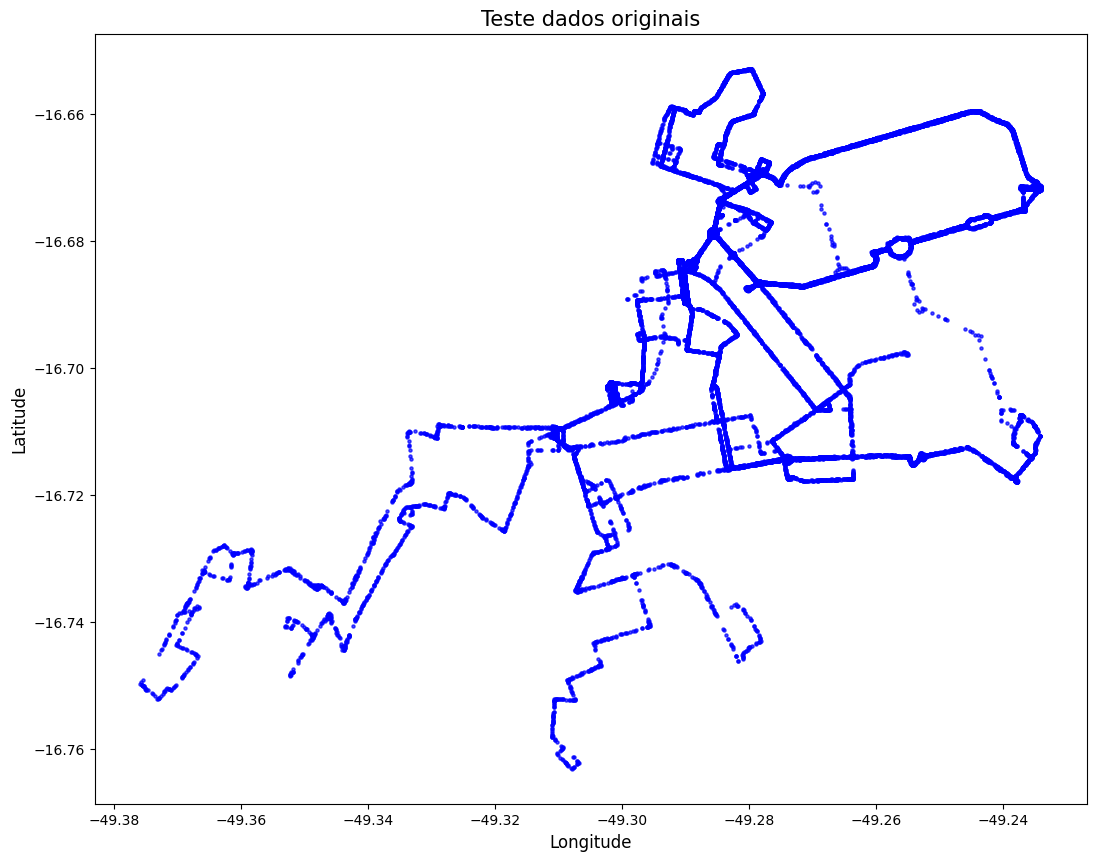

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotar a linha de viagem
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, linestyle='-', alpha=0.7)

# Adicionar títulos e rótulos
ax.set_title('Teste dados originais', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

plt.show()

#### Dados processados com sugestões

In [29]:
specific_date = '2024-04-08'

In [30]:
gdf = gpd.GeoDataFrame(filtered_proposal_df, geometry=gpd.points_from_xy(filtered_proposal_df.Longitude, filtered_proposal_df.Latitude))

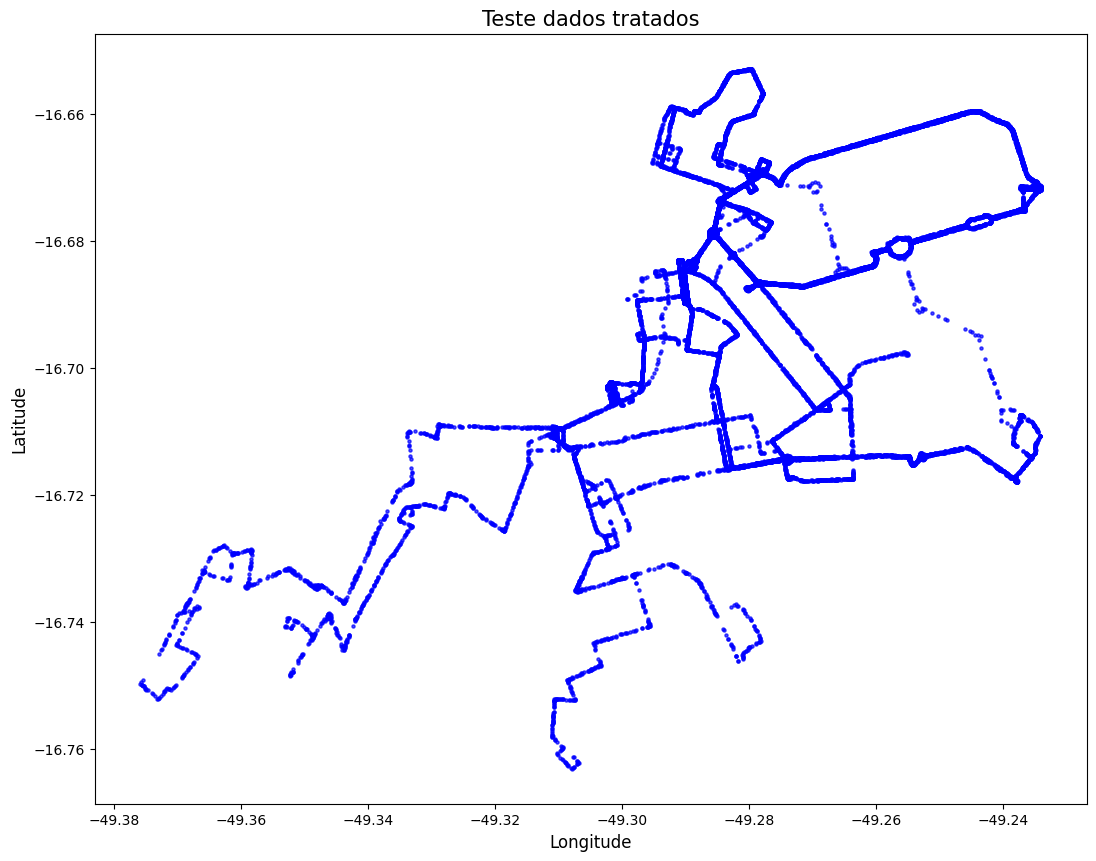

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotar a linha de viagem
gdf.plot(ax=ax, marker='o', color='blue', markersize=5, linestyle='-', alpha=0.7)

# Adicionar títulos e rótulos
ax.set_title('Teste dados tratados', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.show()

plt.show()

### Resumo da analise do dataset Positions

#### A analise abaixo corresponde a dados extraídos dos dias 02/02/2024 a 8/06/2024.

* Latitude e Longitude: A precisão utilizada nos dados de geolocalização são de 15 casas decimais, o que é um exagero para a finalidade que estamos utilizando que é monitoramento de veículo. Segundo pesquisas (vide fonte), 8 casas é o recomendável para níveis considerados de precisão como agricultura de precisão ou estudo cientificos. 5 casas decimais (precisão de ~1,11 m) e 6 casas decimais (precisão de 11 cm) são mais do que suficiente para nossa finalidade. Ao final demontrarei uma tendencia de ocupação de espaço em disco, juntamente com outras medidas que serã sugeridas.
links: 
1. https://rapidlasso.de/england-releases-national-lidar-dem-with-insane-vertical-resolution/ 
2. https://en.wikipedia.org/wiki/Decimal_degrees


* **AgeOfReadingSeconds:** É o tempo de intervalo entre os dados, a média está em 4 segundos, acho que podemos agrupar estas informações para um tempo maior a não que cause algum evento, a finalidade é reduzir informações repetidas sem valor.
* **Pdop:** É um campo que possui informações zeradas, verificar se com os novos veículos estas informações serão preenchidas.
* **Hdop:** É um campo que possui informações, dentre estas informações temo 0,25% das informações com o valor zero, 96,19% com valor 1, registros que vão de 2 a 9 com baixa representatividade (menor que 1%) e o valor 25 que presenta 3,45% dos registros.
* **NumberOfSatellites:** Número de satelites identificados, realmente esta informação é necessária?
* **Heading:** Verificar o significado
* **SpeedKilometresPerHour:** Velocidade do veículo, possui algumas informações zeradas, mas normais no processo.
* **FormattedAddress:** Possui perto de 50% de valores nulo, de certa forma este campo é redundante com a geolocalização, podendo caso necessário ser obtido posteriormente, nas camadas de transformação (cleaned) ou de fornecimento (trusted), após agregação, motivo: Dados em string ocupam muito espaço em memória.
* **AltitudeMetres:** Possui 61% (1.707.800) de valores zerados, estas informações são relevantes? Os novos carros passarão a fornecer estes dados?
* **OdometerKilometres:** Está fornecendo informações nulas em alguns casos 2536, precisamos aplicar alguma regra de negócio nestes casos.

#### Proposta
1. Trucagem nas casas decimais
2. Retirada das colunas ['Pdop','NumberOfSatellites','FormattedAddress','AltitudeMetres']
3. Agrupamento dos campos calculados, principalmente devido a truncagem das geolocalizações
##### Comparação
Foi selecionado um dia aleatóriamente ('2024-04-08') para comparar os resultados.

**Dados originais**
>Memória total usada pelo DataFrame: 6.49 MB

**Dados tratados**
>Memória total usada pelo DataFrame: 1.90 MB

**Resultado**
Com a proposta aplicada conseguimos reduzir mais de 70% do tamanho de armazenamento.